In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

import transport_signal_processing as tsp
from data_manager import DataManager

In [2]:
import matplotlib

font = {'family': 'Arial',
        'size': 16}
matplotlib.rc('font', **font)

### Select data

In [3]:
# parameters
path = "K238A_25C_120mV_20211*08-TotAG-2M*"
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# keep only selected polymers in dataframe and signal info
df = df[(df['selected'] > (int(selected_only)-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# debug display
display(df)

,pore,temperature,voltage,polymer_name,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel
0,K238A,25,120,20211908-TotAG-2M,002,4,2,"[701020, 1066538]",3.65518,2021-10-19_12:04:54,127.858233,2.592570,16,14.0,14.0,1.0,1.000000
1,K238A,25,120,20211908-TotAG-2M,002,4,3,"[1120381, 2094499]",9.74118,2021-10-19_12:04:54,127.223065,2.439562,78,71.0,71.0,1.0,1.000000
2,K238A,25,120,20211908-TotAG-2M,002,4,4,"[2146224, 3098977]",9.52753,2021-10-19_12:04:54,127.505102,2.523215,96,80.0,80.0,1.0,0.987500
3,K238A,25,120,20211908-TotAG-2M,002,4,5,"[3143826, 3641515]",4.97689,2021-10-19_12:04:54,127.640474,2.508203,67,61.0,61.0,1.0,0.983607
4,K238A,25,120,20211908-TotAG-2M,002,4,6,"[3689544, 4454763]",7.65219,2021-10-19_12:04:54,127.605747,2.461832,139,130.0,130.0,1.0,0.984615
5,K238A,25,120,20211908-TotAG-2M,002,4,7,"[4505915, 5267212]",7.61297,2021-10-19_12:04:54,127.735492,2.491591,54,43.0,43.0,1.0,1.000000
6,K238A,25,120,20211908-TotAG-2M,002,4,8,"[5303391, 5631803]",3.28412,2021-10-19_12:04:54,128.292488,2.578031,15,13.0,13.0,1.0,0.923077
7,K238A,25,120,20211908-TotAG-2M,002,4,9,"[5685963, 6126053]",4.40090,2021-10-19_12:04:54,127.946008,2.477761,44,41.0,41.0,1.0,0.975610
8,K238A,25,120,20211908-TotAG-2M,002,4,10,"[6168276, 6303771]",1.35495,2021-10-19_12:04:54,129.683199,2.807477,9,7.0,7.0,1.0,1.000000
9,K238A,25,120,20211908-TotAG-2M,002,4,12,"[6484879, 6902827]",4.17948,2021-10-19_12:04:54,127.951656,2.484883,76,65.0,65.0,1.0,1.000000


### Load data

In [4]:
# load core events
cores_all = []
reduced_all = []
stats_all = []
M = 0
N = 0
for i in range(len(sinfo_l)):
    # get path within the database
    sinfo = sinfo_l[i]
    curr_path = sigman.define_db_path(sinfo)
    # load cores & reduced and filter keep only selected ones
    m = sigman.load_data(curr_path, 's{}-selected'.format(sinfo['sid']))[0].astype(bool)
    c = sigman.load_data(curr_path, 's{}-core-events'.format(sinfo['sid']))[0][m]
    r = sigman.load_data(curr_path, 's{}-reduced-events'.format(sinfo['sid']))[0][m]
    s = sigman.load_data(curr_path, 's{}-stats'.format(sinfo['sid']))[0][m]
    # get selected stats
    M += np.sum(m)
    N += m.shape[0]
    # process events
    for k in range(len(c)):
        # time [s] -> [ms]
        c[k][:,0] = 1e3 * c[k][:,0]
        r[k][:,0] = 1e3 * r[k][:,0]
        s[k][0] = 1e3 * s[k][0]
        # current -> relative current
        c[k][:,1] = 1e2 * c[k][:,1] / sinfo['mI_open']
        r[k][:,1] = 1e2 * r[k][:,1] / sinfo['mI_open']
        s[k][1] = 1e2 * s[k][1] / sinfo['mI_open']
        #s[k][2] = 1e2 * s[k][2] / sinfo['mI_open']
    
    # append data
    cores_all += list(c)
    reduced_all += list(r)
    stats_all += list(s)

# pack data
stats_all = np.array(stats_all)[:,:2]

# debug print
print("selected precentage: {:.1f}%".format(1e2*M/N))

selected precentage: 98.4%


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


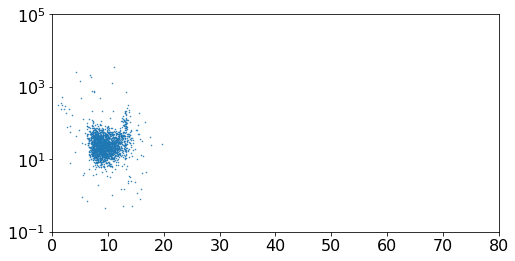

In [5]:
# plot
plt.figure(figsize=(8,4))
plt.semilogy(stats_all[:,1], stats_all[:,0], '.', ms=1.0)
plt.xlim(0.0, 80.0)
plt.ylim(0.1, 100000.0)
plt.show()

### Clustering

In [6]:
# parameters
N_interp = 200

# interpolate events
X = np.array([tsp.signals.downsample(x[:,1], N_interp) for x in cores_all])

In [7]:
# parameters
N_clst = 16

# clustering
clst = KMeans(N_clst)
clst.fit(X)

# get labels
y = clst.labels_

# split by clusters
X_l = []
ic_l = []
for i in np.unique(y):
    ids = np.where(y == i)[0]
    X_l.append(X[ids])
    ic_l.append(ids)

# get cluster centers
Xc = clst.cluster_centers_

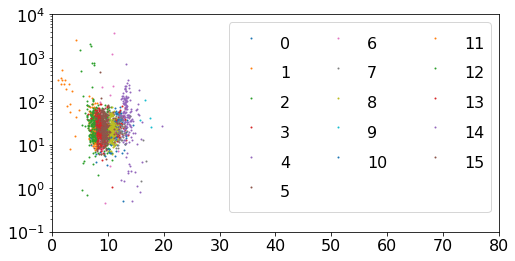

In [14]:
# plot
plt.figure(figsize=(8,4))
for i in np.unique(y):
    ids = np.where(y == i)[0]
    plt.semilogy(stats_all[ids,1], stats_all[ids,0], '.', ms=2.0, label=str(i))

plt.legend(loc='best', ncol=3, handleheight=2.4, labelspacing=0.05)
plt.xlim(0.0, 80.0)
plt.ylim(0.1, 10000.0)
#plt.savefig('graphs/TotAG_K238A/clustering-scatter-190mV.png', dpi=300)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


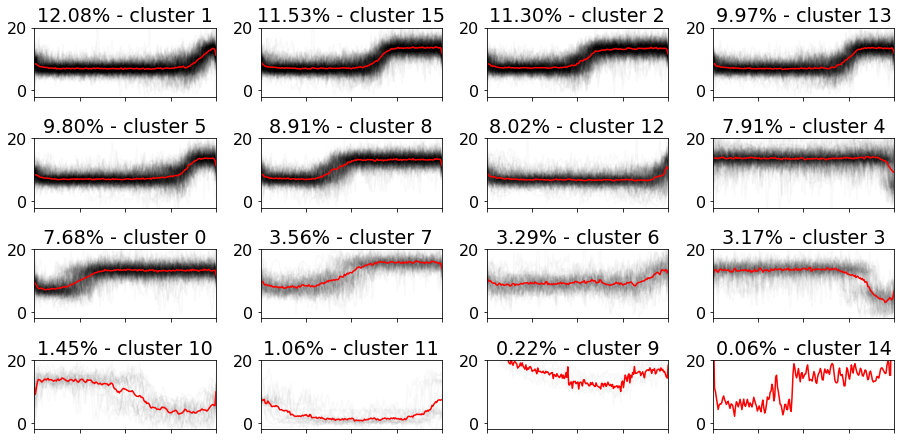

In [9]:
# parameters
ncol = 4
nrow = 4

# check
assert ncol*nrow == N_clst

# define x axis points
t = np.linspace(0.0, 1.0, N_interp)

# sort by cluster size
ids_srtd = np.argsort([1e2*x.shape[0]/M for x in X_l])[::-1]

# plots
#plt.figure(figsize=(3.2*ncol,1.6*nrow))
plt.figure(figsize=(3.2*ncol,1.6*nrow))
ptot = 0.0
for i in range(nrow):
    for j in range(ncol):
        # get 1d index
        k_ = ncol*i+j
        k = ids_srtd[k_]
        # subplot
        plt.subplot(nrow, ncol, k_+1)
        for x in X_l[k]:
            plt.plot(t, x, 'k-', alpha=0.025)
        plt.plot(t, Xc[k], 'r-')
        plt.xlim(0.0, 1.0)
        plt.ylim(-2.0,20.0)
        plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ['', '', '', '', ''])
        plt.title('{:.2f}% - cluster {}'.format(1e2*X_l[k].shape[0]/M, k))
        ptot += 1e2*X_l[k].shape[0]/M

plt.tight_layout()
plt.show()

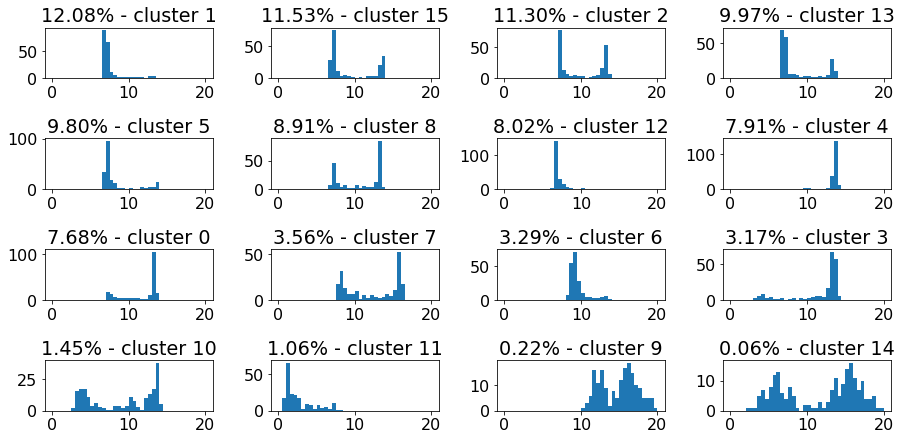

In [10]:
# parameters
ncol = 4
nrow = 4

# check
assert ncol*nrow == N_clst

# define x axis points
t = np.linspace(0.0, 1.0, N_interp)

# sort by cluster size
ids_srtd = np.argsort([1e2*x.shape[0]/M for x in X_l])[::-1]

# plots
#plt.figure(figsize=(3.2*ncol,1.6*nrow))
plt.figure(figsize=(3.2*ncol,1.6*nrow))
ptot = 0.0
for i in range(nrow):
    for j in range(ncol):
        # get 1d index
        k_ = ncol*i+j
        k = ids_srtd[k_]
        # subplot
        plt.subplot(nrow, ncol, k_+1)
        #plt.hist([np.concatenate([x for x in X_l[k]]), Xc[k]], bins=40, range=(0.0, 20.0), histtype='step', density=True)
        plt.hist(Xc[k], bins=40, range=(0.0, 20.0))
        #plt.xlim(0.0, 1.0)
        #plt.ylim(-2.0,20.0)
        #plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ['', '', '', '', ''])
        plt.title('{:.2f}% - cluster {}'.format(1e2*X_l[k].shape[0]/M, k))
        ptot += 1e2*X_l[k].shape[0]/M

plt.tight_layout()
plt.show()

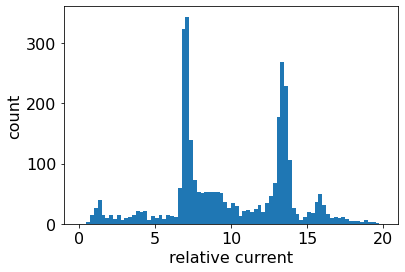

In [15]:
plt.figure()
plt.hist(np.concatenate(Xc), bins=80, range=(0,20))
plt.xlabel('relative current')
plt.ylabel('count')
plt.show()

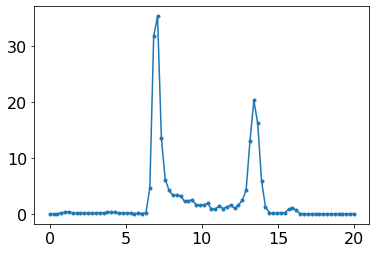

In [12]:
# weighted histograms by cluster size
counts = np.array([len(x_l) for x_l in X_l])
H = np.stack([np.histogram(xc, bins=80, range=(0.0, 20.0))[0] for xc in Xc], axis=0)
Z = np.sum(H * (counts / np.sum(counts)).reshape(-1,1), axis=0)

# plot
plt.figure()
plt.plot(np.linspace(0.0, 20.0, 80), Z, '.-')
plt.show()